In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Devise

In [2]:
from fastai.conv_learner import *
torch.backends.cudnn.benchmark=True

import fastText as ft

In [3]:
PATH = Path('data/imagenet/')
TMP_PATH = PATH/'tmp'
TRANS_PATH = Path('data/translate/')
PATH_TRN = PATH/'train'

In [89]:
ft_vecs = ft.load_model(str((TRANS_PATH/'wiki.en.bin')))

In [106]:
ft_vecs.get_word_vector('king')

array([ 0.03259, -0.18164, -0.29049, -0.10506, -0.16712, -0.07748, -0.5661 , -0.08622, -0.00216,  0.15366,
        0.12189, -0.14722,  0.01511,  0.07209, -0.02156, -0.20612, -0.02104, -0.01999, -0.15506,  0.00802,
       -0.22746,  0.33518, -0.10629, -0.50318, -0.1582 ,  0.27829,  0.05752, -0.32697,  0.04766,  0.01076,
        0.13972, -0.12445, -0.18989,  0.32969, -0.32513,  0.10958,  0.21962, -0.47215,  0.03422, -0.2207 ,
        0.02177,  0.0832 , -0.04776, -0.48873,  0.05207, -0.15001, -0.19203,  0.06177,  0.15535, -0.05598,
        0.11071,  0.39161, -0.17716,  0.05449,  0.25898, -0.13954,  0.4272 , -0.07273, -0.4714 ,  0.04993,
        0.29526, -0.05319,  0.03451, -0.10583, -0.30137,  0.16372,  0.07541,  0.21018, -0.11459,  0.10976,
        0.04923,  0.17688,  0.45658, -0.59762, -0.0039 ,  0.08866,  0.53103,  0.153  , -0.1673 ,  0.13121,
       -0.05547, -0.03582, -0.34535,  0.09128,  0.03323,  0.45211, -0.16894,  0.21139,  0.24153,  0.51014,
       -0.01474, -0.47179,  0.2235 , 

In [91]:
np.corrcoef(ft_vecs.get_word_vector('jeremy'), ft_vecs.get_word_vector('Jeremy'))

array([[1.     , 0.60866],
       [0.60866, 1.     ]])

In [92]:
np.corrcoef(ft_vecs.get_word_vector('banana'), ft_vecs.get_word_vector('Jeremy'))

array([[1.     , 0.14482],
       [0.14482, 1.     ]])

### Map imagenet classes to word vectors

In [93]:
ft_words = ft_vecs.get_words(include_freq=True)
ft_word_dict = {k:v for k,v in zip(*ft_words)}
ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])

len(ft_words)

2519370

In [4]:
from fastai.io import get_data

In [5]:
CLASSES_FN = 'imagenet_class_index.json'
get_data(f'http://files.fast.ai/models/{CLASSES_FN}', TMP_PATH/CLASSES_FN)

In [6]:
WORDS_FN = 'classids.txt'
get_data(f'http://files.fast.ai/data/{WORDS_FN}', PATH/WORDS_FN)

In [7]:
class_dict = json.load((TMP_PATH/CLASSES_FN).open())
classids_1k = dict(class_dict.values())
nclass = len(class_dict); nclass

1000

In [8]:
class_dict['0']

['n01440764', 'tench']

In [9]:
classid_lines = (PATH/WORDS_FN).open().readlines()
classid_lines[:5]

['n00001740 entity\n',
 'n00001930 physical_entity\n',
 'n00002137 abstraction\n',
 'n00002452 thing\n',
 'n00002684 object\n']

In [10]:
classids = dict(l.strip().split() for l in classid_lines)
len(classids),len(classids_1k)

(82115, 1000)

In [101]:
lc_vec_d = {w.lower(): ft_vecs.get_word_vector(w) for w in ft_words[-1000000:]}

In [102]:
syn_wv = [(k, lc_vec_d[v.lower()]) for k,v in classids.items()
          if v.lower() in lc_vec_d]
syn_wv_1k = [(k, lc_vec_d[v.lower()]) for k,v in classids_1k.items()
          if v.lower() in lc_vec_d]
syn2wv = dict(syn_wv)
len(syn2wv)

49469

In [103]:
pickle.dump(syn2wv, (TMP_PATH/'syn2wv.pkl').open('wb'))
pickle.dump(syn_wv_1k, (TMP_PATH/'syn_wv_1k.pkl').open('wb'))

In [11]:
syn2wv = pickle.load((TMP_PATH/'syn2wv.pkl').open('rb'))
syn_wv_1k = pickle.load((TMP_PATH/'syn_wv_1k.pkl').open('rb'))

In [38]:
images = []
img_vecs = []

for d in (PATH/'train').iterdir():
    if d.name not in syn2wv: continue
    vec = syn2wv[d.name]
    for f in d.iterdir():
        images.append(str(f.relative_to(PATH)))
        img_vecs.append(vec)

n_val=0
for d in (PATH/'valid').iterdir():
    if d.name not in syn2wv: continue
    vec = syn2wv[d.name]
    for f in d.iterdir():
        images.append(str(f.relative_to(PATH)))
        img_vecs.append(vec)
        n_val += 1

In [39]:
n_val

28650

In [13]:
img_vecs = np.stack(img_vecs)
img_vecs.shape

In [41]:
pickle.dump(images, (TMP_PATH/'images.pkl').open('wb'))
pickle.dump(img_vecs, (TMP_PATH/'img_vecs.pkl').open('wb'))

In [12]:
images = pickle.load((TMP_PATH/'images.pkl').open('rb'))
img_vecs = pickle.load((TMP_PATH/'img_vecs.pkl').open('rb'))

In [13]:
arch = resnet50

In [14]:
n = len(images); n

766876

In [15]:
val_idxs = list(range(n-28650, n))

In [16]:
tfms = tfms_from_model(arch, 224, transforms_side_on, max_zoom=1.1)
md = ImageClassifierData.from_names_and_array(PATH, images, img_vecs, val_idxs=val_idxs,
        classes=None, tfms=tfms, continuous=True, bs=256)

In [7]:
x,y = next(iter(md.val_dl))

In [53]:
models = ConvnetBuilder(arch, md.c, is_multi=False, is_reg=True, xtra_fc=[1024], ps=[0.2,0.2])

learn = ConvLearner(md, models, precompute=True)
learn.opt_fn = partial(optim.Adam, betas=(0.9,0.99))

/home/ubuntu/fastai/courses/dl2/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [54]:
def cos_loss(inp,targ): return 1 - F.cosine_similarity(inp,targ).mean()
learn.crit = cos_loss

In [ ]:
learn.lr_find(start_lr=1e-4, end_lr=1e15)

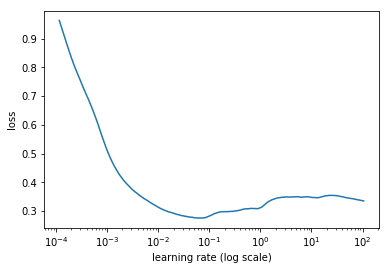

In [242]:
learn.sched.plot()

In [55]:
lr = 1e-2
wd = 1e-7

In [85]:
learn.precompute=True

In [26]:
learn.fit(lr, 1, cycle_len=20, wds=wd, use_clr=(20,10))

epoch      trn_loss   val_loss                                  
    0      0.104692   0.125685  
    1      0.112455   0.129307                                 
    2      0.110631   0.126568                                 
    3      0.108629   0.127338                                 
    4      0.110791   0.125033                                 
    5      0.108859   0.125186                                 
    6      0.106582   0.123875                                 
    7      0.103227   0.123945                                 
    8      0.10396    0.12304                                  
    9      0.105898   0.124894                                 
    10     0.10498    0.122582                                 
    11     0.104983   0.122906                                 
    12     0.102317   0.121171                                  
    13     0.10017    0.121816                                  
    14     0.099454   0.119647                                  
   

[0.11790786389489033]

In [86]:
learn.bn_freeze(True)

In [26]:
learn.fit(lr, 1, cycle_len=20, wds=wd, use_clr=(20,10))

epoch      trn_loss   val_loss                                  
    0      0.104692   0.125685  
    1      0.112455   0.129307                                 
    2      0.110631   0.126568                                 
    3      0.108629   0.127338                                 
    4      0.110791   0.125033                                 
    5      0.108859   0.125186                                 
    6      0.106582   0.123875                                 
    7      0.103227   0.123945                                 
    8      0.10396    0.12304                                  
    9      0.105898   0.124894                                 
    10     0.10498    0.122582                                 
    11     0.104983   0.122906                                 
    12     0.102317   0.121171                                  
    13     0.10017    0.121816                                  
    14     0.099454   0.119647                                  
   

[0.11790786389489033]

In [24]:
lrs = np.array([lr/1000,lr/100,lr])

In [57]:
learn.precompute=False
learn.freeze_to(1)

In [29]:
learn.save('pre0')

In [58]:
learn.load('pre0')

## Image search

### Search imagenet classes

In [88]:
syns, wvs = list(zip(*syn_wv_1k))
wvs = np.array(wvs)

In [89]:
%time pred_wv = learn.predict()

CPU times: user 18.4 s, sys: 7.91 s, total: 26.3 s
Wall time: 7.17 s


In [90]:
start=300

In [91]:
denorm = md.val_ds.denorm

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.axis('off')
    return ax

def show_imgs(ims, cols, figsize=None):
    fig,axes = plt.subplots(len(ims)//cols, cols, figsize=figsize)
    for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
    plt.tight_layout()

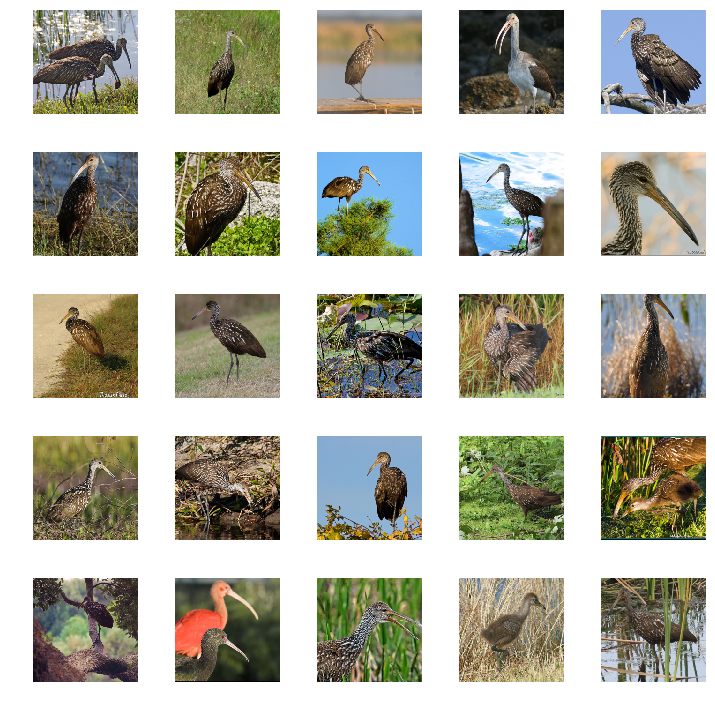

In [92]:
show_imgs(denorm(md.val_ds[start:start+25][0]), 5, (10,10))

In [94]:
import nmslib

def create_index(a):
    index = nmslib.init(space='angulardist')
    index.addDataPointBatch(a)
    index.createIndex()
    return index

def get_knns(index, vecs):
     return zip(*index.knnQueryBatch(vecs, k=10, num_threads=4))

def get_knn(index, vec): return index.knnQuery(vec, k=10)

In [95]:
nn_wvs = create_index(wvs)

In [96]:
idxs,dists = get_knns(nn_wvs, pred_wv)

In [97]:
[[classids[syns[id]] for id in ids[:3]] for ids in idxs[start:start+10]]

[['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['spoonbill', 'bustard', 'oystercatcher'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill']]

### Search all wordnet noun classes

In [98]:
all_syns, all_wvs = list(zip(*syn2wv.items()))
all_wvs = np.array(all_wvs)

In [99]:
nn_allwvs = create_index(all_wvs)

In [100]:
idxs,dists = get_knns(nn_allwvs, pred_wv)

In [101]:
[[classids[all_syns[id]] for id in ids[:3]] for ids in idxs[start:start+10]]

[['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['spoonbill', 'bustard', 'oystercatcher'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill'],
 ['limpkin', 'oystercatcher', 'spoonbill']]

### Text -> image search

In [102]:
nn_predwv = create_index(pred_wv)

In [103]:
en_vecd = pickle.load(open(TRANS_PATH/'wiki.en.pkl','rb'))

In [104]:
vec = en_vecd['boat']

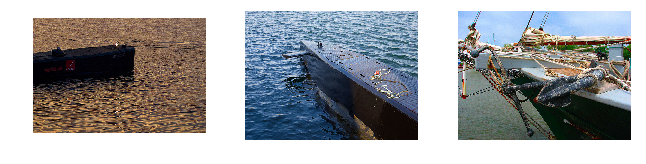

In [105]:
idxs,dists = get_knn(nn_predwv, vec)
show_imgs([open_image(PATH/md.val_ds.fnames[i]) for i in idxs[:3]], 3, figsize=(9,3));

In [106]:
vec = (en_vecd['engine'] + en_vecd['boat'])/2

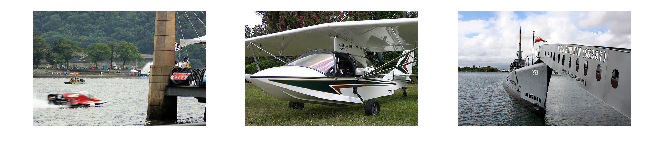

In [107]:
idxs,dists = get_knn(nn_predwv, vec)
show_imgs([open_image(PATH/md.val_ds.fnames[i]) for i in idxs[:3]], 3, figsize=(9,3));

In [108]:
vec = (en_vecd['sail'] + en_vecd['boat'])/2

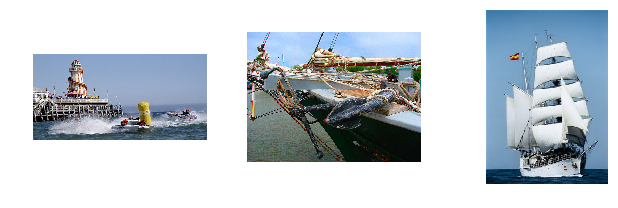

In [79]:
idxs,dists = get_knn(nn_predwv, vec)
show_imgs([open_image(PATH/md.val_ds.fnames[i]) for i in idxs[:3]], 3, figsize=(9,3));

### Image->image

In [80]:
fname = 'valid/n01440764/ILSVRC2012_val_00007197.JPEG'

In [81]:
img = open_image(PATH/fname)

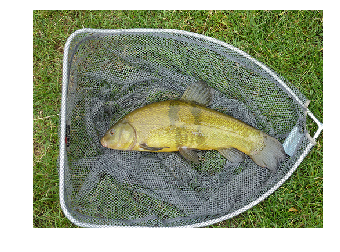

In [82]:
show_img(img);

In [83]:
t_img = md.val_ds.transform(img)
pred = learn.predict_array(t_img[None])

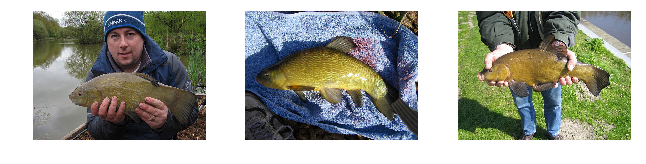

In [84]:
idxs,dists = get_knn(nn_predwv, pred)
show_imgs([open_image(PATH/md.val_ds.fnames[i]) for i in idxs[1:4]], 3, figsize=(9,3));